# Simple Simulation Analysis

In this notebook I will analyse the output of a simple simulation. First, I load the output data of the two stations.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from e_sim.sim_components import Simulator
from e_sim.utils import experiment_runner, compute_avg_cost, agg_data

## Run simulations

Run the simulation for several settings for the batch sizes and rates

In [11]:
# Common settings of the simulation
sim_time = 1000

# Settings dict
settings = {}
settings['demand_rate'] = [1]
settings['repair_rate'] = [0.5]
settings['Q_service'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
settings['Q_repair'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
settings['S_depot'] = [1]
settings['S_warehouse'] = [2]
settings['init_stock_depot'] = [2, 4]
settings['init_stock_warehouse'] = [2, 8]

# Costs
costs = {}
costs['backorder'] = 0.4
costs['holding'] = 0.02
costs['c_service'] = 1
costs['c_repair'] = 2

# Run all combinations of experiments
sim_dfs = experiment_runner(settings, sim_time)

# Save info 
sim_dfs.to_csv('../output/experiment_output.csv')

100%|██████████| 400/400 [1:11:26<00:00,  9.76s/it]


## Visualisation of stock over time

The stock levels of the repairable and servicable units are recorded over time. Let's check these.

In [12]:
# Get a feeling for the data
sim_dfs.head()

,time,service_stock_depot,service_orders,service_back_orders,service_stock_position,repair_stock_depot,service_stock_warehouse,repair_stock_warehouse,items_in_repair,DEMAND,...,SHIP_SERVICE,Q_repair,Q_service,S_depot,S_warehouse,demand_rate,init_stock_depot,init_stock_warehouse,repair_rate,settings
0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1,...,0,1,1,1,2,1,2,2,0.5,"Q_repair=1, Q_service=1, S_depot=1, S_warehous..."
1,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,...,0,1,1,1,2,1,2,2,0.5,"Q_repair=1, Q_service=1, S_depot=1, S_warehous..."
2,2.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,1,1,1,2,1,2,2,0.5,"Q_repair=1, Q_service=1, S_depot=1, S_warehous..."
3,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,...,2,1,1,1,2,1,2,2,0.5,"Q_repair=1, Q_service=1, S_depot=1, S_warehous..."
4,3.5,2.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,...,1,1,1,1,2,1,2,2,0.5,"Q_repair=1, Q_service=1, S_depot=1, S_warehous..."


In [4]:
# Get all relevant inventory level variables
# Create long format
inventory_data = sim_dfs.melt(value_vars=['service_stock_depot', 'service_stock_position', 'service_back_orders', 'repair_stock_depot', 'service_stock_warehouse', 'repair_stock_warehouse'], 
                              id_vars=['time', 'settings'],
                              value_name='inventory_level', var_name='inventory_type'
                              )

# Plot lines over time 
#g = sns.FacetGrid(inventory_data[inventory_data.time >= 0], col='settings', col_wrap=1, hue='inventory_type', aspect=3, sharey=False)

# Plot lines
#g.map(plt.step, 'time', 'inventory_level', where='post').add_legend().set_axis_labels('Time', 'Inventory level')

## Compute the average cycle cost

In this simple model, we assume that sending a batch from the warehouse to the depot has a cost `c_d` and sending a batch of repairable units from the depot to the warehouse costs `c_r`. In general we have that `c_r` > `c_d`, since the reverse flow is typically less efficient. Besides, set-up costs for orders, a holding costs of `h_d` per unit per unit of time for stock of servicable units at the depot has to be paid. In case of a shortage, a backlogging cost of `b_d` per unit per unit of time is incurred. For now, I do not assume any holding cost for the repairable units.

In [13]:
# Transform data types to float
df_agg = sim_dfs.groupby(list(settings.keys())).apply(agg_data)

### Average inventory levels per cycle

The table below shows the average inventory level of the system and the mean number of shipments per unit of time. Note that we assume that the inventory level is constant over time since we do not have a system with external ordering and items are considered to have the same inventory holding costs no matter its state.

In [14]:
df_agg

avg_stock  \
demand_rate repair_rate Q_service Q_repair S_depot S_warehouse init_stock_depot init_stock_warehouse                
1           0.5         1         1        1       2           2                2                    0          4   
                                                                                8                    0         10   
                                                               4                2                    0          6   
                                                                                8                    0         12   
                                  2        1       2           2                2                    0          4   
                                                                                8                    0         10   
                                                               4                2                    0          6   
                                                                                8                    0         12   
                                  3        1       2           2                2                    0          4   
                                                                                8                    0         10   
                                                               4                2                    0          6   
                                                                                8                    0         12   
                                  4        1       2           2                2                    0          4   
                                                                                8                    0         10   
                                                               4                2                    0          6   
                                                                                8                    0         12   
                                  5        1       2           2                2                    0          4   
                                                                                8                    0         10   
                                                               4                2                    0          6   
                                                                                8                    0         12   
                                  6        1       2           2                2                    0          4   
                                                                                8                    0         10   
                                                               4                2                    0          6   
                                                                                8                    0         12   
                                  7        1       2           2                2                    0          4   
                                                                                8                    0         10   
                                                               4                2                    0          6   
                                                                                8                    0         12   
                                  8        1       2           2                2                    0          4   
                                                                                8                    0         10   
...                                                                                                           ...   
                        10        3        1       2           4                2                    0          6   
                                                                                8                    0         12   
         

### Average costs for basis cost

In [15]:
df_avg_cost = df_agg.groupby(list(settings.keys())).apply(compute_avg_cost, costs)

In [16]:
df_avg_cost

holding_cost  \
demand_rate repair_rate Q_service Q_repair S_depot S_warehouse init_stock_depot init_stock_warehouse                   
1           0.5         1         1        1       2           2                2                    0          0.08   
                                                                                8                    0          0.20   
                                                               4                2                    0          0.12   
                                                                                8                    0          0.24   
                                  2        1       2           2                2                    0          0.08   
                                                                                8                    0          0.20   
                                                               4                2                    0          0.12   
                                                                                8                    0          0.24   
                                  3        1       2           2                2                    0          0.08   
                                                                                8                    0          0.20   
                                                               4                2                    0          0.12   
                                                                                8                    0          0.24   
                                  4        1       2           2                2                    0          0.08   
                                                                                8                    0          0.20   
                                                               4                2                    0          0.12   
                                                                                8                    0          0.24   
                                  5        1       2           2                2                    0          0.08   
                                                                                8                    0          0.20   
                                                               4                2                    0          0.12   
                                                                                8                    0          0.24   
                                  6        1       2           2                2                    0          0.08   
                                                                                8                    0          0.20   
                                                               4                2                    0          0.12   
                                                                                8                    0          0.24   
                                  7        1       2           2                2                    0          0.08   
                                                                                8                    0          0.20   
                                                               4                2                    0          0.12   
                                                                                8                    0          0.24   
                                  8        1       2           2                2                    0          0.08   
                                                                                8                    0          0.20   
...                                                                                                              ...   
                        10        3        1       2           4                2                    0          0.12   
                        

Index(['demand_rate', 'repair_rate', 'Q_service', 'Q_repair', 'S_depot',
       'S_warehouse', 'init_stock_depot', 'init_stock_warehouse', 'level_8',
       'holding_cost', 'back_order_cost', 'setup_repair_cost',
       'setup_service_cost', 'average_cost'],
      dtype='object')

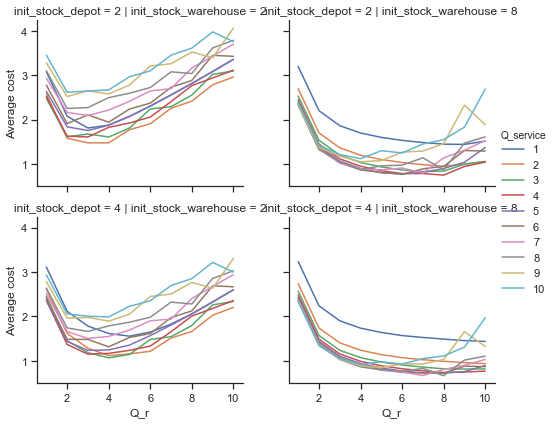

In [17]:
# Reset index variables
df_avg_cost_plot = df_avg_cost.reset_index()
df_avg_cost_plot.columns

g = sns.FacetGrid(df_avg_cost_plot, row='init_stock_depot', col='init_stock_warehouse', hue='Q_service', aspect=1.2, sharey=True)
g.map(plt.plot, 'Q_repair', 'average_cost').add_legend().set_axis_labels('Q_r', 'Average cost')

### Sensitivity analysis for cost variables